In [1]:
import numpy as np
import pylab as plt

import chainer
import chainer.functions as F
import chainer.links as L

from chainer import datasets

/miniconda3/lib/python3.7/site-packages/chainer/_environment_check.py:37: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


## Dataset

In [2]:
class MnistTripletDataset(chainer.dataset.DatasetMixin):

    def __init__(self):
        train, test = datasets.get_mnist()

        self.X = []
        self.T = []
        self.t2inds = {}
        self.labels = np.arange(7, dtype=np.int32)

        ind = 0
        for x, t in train:
            if t != 0 and np.random.random() > 0.01:
                continue
            if t >= 7:
                continue

            if t not in self.t2inds:
                self.t2inds[t] = []
            self.X.append(x)
            self.T.append(t)
            self.t2inds[t].append(ind)
            ind += 1

        self.X = np.array(self.X, dtype=np.float32)
        self.T = np.array(self.T, dtype=np.int32)

    def __len__(self):
        return len(self.T)

    def get_example(self, i):
        x = self.X[i].reshape(1, 28, 28)
        t = self.T[i]

        # positive sample
        ind_p = np.random.choice(self.t2inds[t])
        x_p = self.X[ind_p].reshape(1, 28, 28)

        # negative sample
        label = np.random.choice(self.labels[self.labels!=t])
        ind_n = np.random.choice(self.t2inds[label])
        x_n = self.X[ind_n].reshape(1, 28, 28)

        return x, t, x_p, x_n

In [3]:
dataset = MnistTripletDataset()

In [4]:
len(dataset)

6274

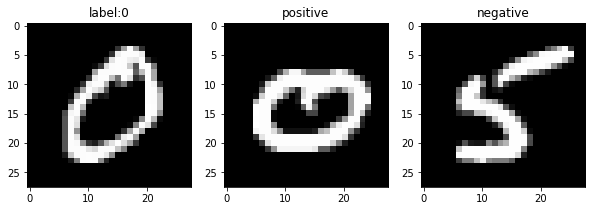

In [5]:
x, t, x_p, x_n = dataset[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('label:{}'.format(t))
plt.imshow(x.reshape(28, 28), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('positive')
plt.imshow(x_p.reshape(28, 28), cmap='gray')

plt.subplot(1, 3, 3)
plt.title('negative')
plt.imshow(x_n.reshape(28, 28), cmap='gray')

## Model

In [6]:
class Model(chainer.Chain):
    def __init__(self, dim=256):
        super(Model, self).__init__()
        with self.init_scope():
            self.c0 = L.Convolution2D(1, 16, ksize=3, stride=1, pad=1) #(in_channels: number of channels pf inupt arrays, out_channels, ksize*size of filters)
            self.c1 = L.Convolution2D(16, 32, ksize=3, stride=2, pad=1)
            self.c2 = L.Convolution2D(32, 64, ksize=3, stride=1, pad=1)
            self.c3 = L.Convolution2D(64, 128, ksize=3, stride=2, pad=1)
            self.fc = L.Linear(None, dim)

    def __call__(self, x):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        h = F.relu(self.c2(h))
        h = F.relu(self.c3(h))
        y = self.fc(h)
        return y

In [7]:
class TripletLoss(chainer.Chain):
    def __init__(self, model):
        super(TripletLoss, self).__init__()
        with self.init_scope():
            self.model = model

    def __call__(self, x, t, x_p, x_n):
        y = self.model(x)
        y_p = self.model(x_p)
        y_n = self.model(x_n)
        loss = F.triplet(y, y_p, y_n)
        
        y_0 = y[t==0]
        if len(y_0) > 0:
            loss += F.mean((y_0 ** 2))

        chainer.report({'loss': loss}, self)
        return loss

In [8]:
model = Model()
loss = TripletLoss(model)

## Train

In [9]:
from chainer import iterators
from chainer import training
from chainer.training import extensions

In [10]:
n_epoch = 1
batchsize = 32
out_dir = './result/'
report_interval = (10, 'iteration')

In [11]:
train_iter = iterators.MultithreadIterator(dataset, batchsize, repeat=True, shuffle=True)

In [12]:
optimizer = chainer.optimizers.Adam(alpha=1e-3, amsgrad=True)
optimizer.setup(loss)

In [13]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [14]:
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']),
               trigger=report_interval)
trainer.extend(extensions.PlotReport(y_keys='main/loss', trigger=report_interval))

In [15]:
trainer.run()

epoch       iteration   main/loss 
0           10          0.0773322   
0           20          0.0250603   
0           30          0.0219248   
0           40          0.00773161  
0           50          0.00780652  
0           60          0.0185315   
0           70          0.0116284   
0           80          0.013014    
0           90          0.00781214  
0           100         0.0110306   
0           110         0.010753    
0           120         0.00577637  


KeyboardInterrupt: 

## Evaluate

In [16]:
train, test = datasets.get_mnist()

In [34]:
X = []
T = []
for x, t in test:
    #if t != 0 and np.random.random() > 0.01:
    #    continue
    X.append(x)
    T.append(t)

X = np.array(X,dtype=np.float32).reshape(-1, 1, 28, 28)
T = np.array(T,dtype=np.int32)

In [35]:
Y = model(X).data

### tSNE で可視化してみる

In [36]:
from sklearn.manifold import TSNE #visualize high-dimentional data

In [37]:
Y_embedded = TSNE(n_components=2).fit_transform(Y[:1000])

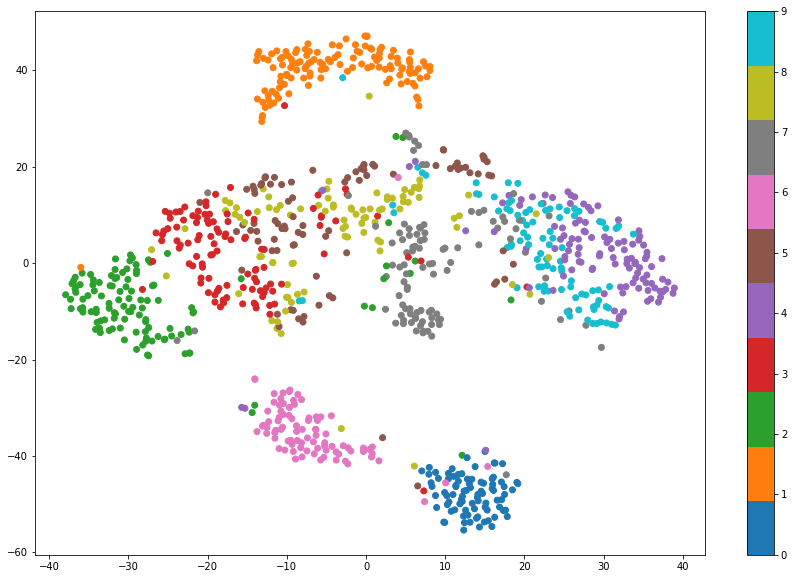

In [38]:
plt.figure(figsize=(15, 10))
plt.scatter(Y_embedded[:, 0], Y_embedded[:,1], c=T[:1000], cmap='tab10')
plt.colorbar()

### Precision Recall Curve を書いてみる

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [40]:
distance_from_origin = np.sqrt(np.sum(Y ** 2, axis=1))

In [41]:
score = distance_from_origin / distance_from_origin.max()

In [42]:
truth = (T != 0)

In [43]:
precision, recall, _ = precision_recall_curve(truth, score)

average_precision = average_precision_score(truth, score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 1.00


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

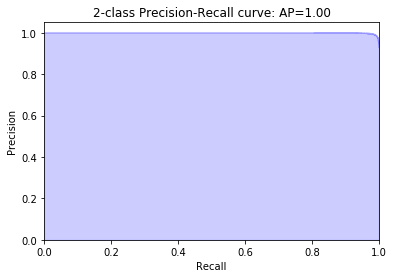

In [44]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [45]:
# chance rate(全部 positive と判定した場合の precision)
len(T[T!=0]) / len(T)

0.902

In [46]:
(T==0).sum()

980

In [47]:
precision

array([0.92903492, 0.92902761, 0.92912331, ..., 1.        , 1.        ,
       1.        ])

In [48]:
recall

array([1.00000000e+00, 9.99889135e-01, 9.99889135e-01, ...,
       2.21729490e-04, 1.10864745e-04, 0.00000000e+00])